In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import datetime
from geopy.geocoders import Nominatim
from pathlib import Path

import openmeteo_requests
import requests_cache

from retry_requests import retry

# Context
- This data comes from the Bigfoot Field Researchers Organization (BFRO), which is dedicated to discovering the truth of Bigfoot's existence.
- The dataset has information about sightings (a text description of the report and a classification), geocoded location data, timestamps, and supplemental weather data from the Dark Sky API.
- [Classification types from the BFRO](https://www.bfro.net/gdb/classify.asp)
    - Class A = low likelihood of misidentification
    - Class B = Observed with big distance/bad lighting/only heard
    - Class C = second-hand/third-hand reports or w/ untraceable sources
- (1) bfro_report_locations - a table view displaying geocoded reports
- (2) bfro_reports - full text reports in line delimited JSON format
- (3) bfro_reports_geocoded - combining & cleaning the report locations along with full text reprots plus weather conditions on day of sighting.
- Each file has been collected on 4/17/19 & updated 8/28/21 respectively

In [2]:
locations_df = pd.read_csv('data/bfro_locations.csv')
reports_df = pd.read_csv('data/bfro_reports.csv')
geocoded_df = pd.read_csv('data/bfro_reports_geocoded.csv')

# BFRO Locations
- 4250 non-null rows
- Column Descriptions:
    - number: The report number of the sighting. (Integer)
    - title: The title of the sighting report. (String)
    - classification: The classification of the sighting. (String)
    - timestamp: The date and time of the sighting. (DateTime)
    - latitude: The latitude of the sighting. (Float)
    - longitude: The longitude of the sighting. (Float) 
- Transformations:
    - Converted 'timestamp' from an object to a datetime
    - Some longitude values were clearly too large (e.g. -9.486840e+07) and were set to values with the decimal after two places.
    - One-hot encoding for classification for correlation
- Insights:
    - There is no significant correlation between classification and latitude/longitude


In [3]:
locations_df

index  number                                              title  \
0         0     637  Report 637: Campers' encounter just after dark...   
1         1    2917  Report 2917: Family observes large biped from car   
2         2    7963  Report 7963: Sasquatch walks past window of ho...   
3         3    9317  Report 9317: Driver on Alcan Highway has noon,...   
4         4   13038  Report 13038: Snowmobiler has encounter in dee...   
...     ...     ...                                                ...   
4245   4245    4159  Report 4159: Campers hear unusual grunting sou...   
4246   4246     175  Report 175: Campers encounter large animal nea...   
4247   4247     945    Report 945: Creature with red glowing eyes seen   
4248   4248    1387  Report 1387: Father and son hear heavy footste...   
4249   4249    3044  Report 3044: Second-hand report of creature lo...   

     classification             timestamp  latitude  longitude  
0           Class A  2000-06-16T12:00:00Z  61.50000 -142.90000  
1           Class A  1995-05-15T12:00:00Z  55.18720 -132.79820  
2           Class A  2004-02-09T12:00:00Z  55.20350 -132.82020  
3           Class A  2004-06-18T12:00:00Z  62.93750 -141.56670  
4           Class A  2004-02-15T12:00:00Z  61.05950 -149.78530  
...             ...                   ...       ...        ...  
4245        Class C  1995-11-15T12:00:00Z  31.22333  -94.96611  
4246        Class C  2000-07-30T12:00:00Z  47.47745 -121.04150  
4247        Class C  1999-03-19T12:00:00Z  47.57778 -124.29330  
4248        Class C  1983-08-17T12:00:00Z  47.51030 -122.04560  
4249        Class C  1975-09-10T12:00:00Z  43.98694  -91.33662  

[4250 rows x 7 columns]

In [4]:
locations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           4250 non-null   int64  
 1   number          4250 non-null   int64  
 2   title           4250 non-null   object 
 3   classification  4250 non-null   object 
 4   timestamp       4250 non-null   object 
 5   latitude        4250 non-null   float64
 6   longitude       4250 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 232.5+ KB


In [5]:
locations_df.describe()

index        number     latitude     longitude
count  4250.000000   4250.000000  4250.000000  4.250000e+03
mean   2124.500000  22586.533647    39.831850 -6.684490e+04
std    1227.013651  19015.127478     6.009091  2.028967e+06
min       0.000000     60.000000    25.141000 -9.486840e+07
25%    1062.250000   6923.750000    35.629365 -1.180889e+02
50%    2124.500000  17230.500000    39.633185 -9.235350e+01
75%    3186.750000  34236.000000    44.824168 -8.316599e+01
max    4249.000000  71997.000000    64.891390 -6.383683e+01

In [6]:
locations_df['longitude'][locations_df['longitude'] < -180]

1167    -3706646.0
1586    -4319942.0
2067      -79625.0
2978   -36588780.0
3139   -94868400.0
3407   -40544270.0
3457   -40757860.0
3995   -61921560.0
4161     -446665.2
4164     -442106.6
Name: longitude, dtype: float64

In [7]:
locations_df.at[1167, 'longitude'] = -37.06646
locations_df.at[1586, 'longitude'] = -43.19942
locations_df.at[2067, 'longitude'] = -79.625
locations_df.at[2978, 'longitude'] = -36.588780
locations_df.at[3139, 'longitude'] = -94.868400
locations_df.at[3407, 'longitude'] = -40.544270
locations_df.at[3457, 'longitude'] = -40.757860
locations_df.at[3995, 'longitude'] = -61.921560
locations_df.at[4161, 'longitude'] = -44.6665
locations_df.at[4164, 'longitude'] = -44.2106

In [8]:
locations_df.describe()

index        number     latitude    longitude
count  4250.000000   4250.000000  4250.000000  4250.000000
mean   2124.500000  22586.533647    39.831850   -97.761034
std    1227.013651  19015.127478     6.009091    17.093641
min       0.000000     60.000000    25.141000  -167.131000
25%    1062.250000   6923.750000    35.629365  -117.976150
50%    2124.500000  17230.500000    39.633185   -92.308965
75%    3186.750000  34236.000000    44.824168   -83.114762
max    4249.000000  71997.000000    64.891390   -36.588780

<Axes: xlabel='latitude', ylabel='Count'>

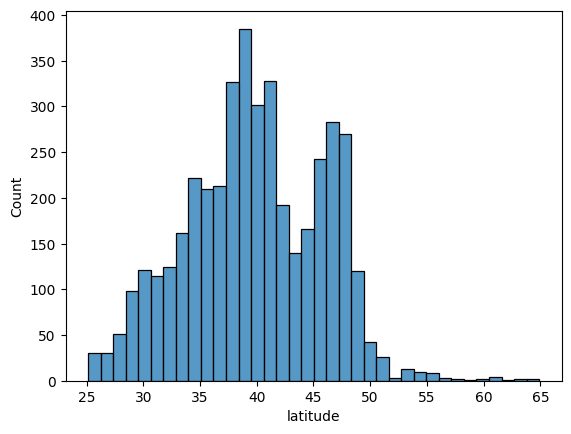

In [9]:
sns.histplot(locations_df['latitude'])

<Axes: xlabel='longitude', ylabel='Count'>

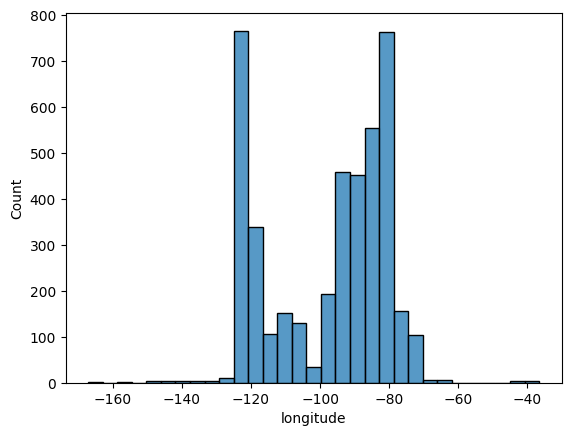

In [10]:
sns.histplot(locations_df['longitude'])

In [11]:
locations_df['classification'].value_counts()

classification
Class B    2138
Class A    2093
Class C      19
Name: count, dtype: int64

In [12]:
locations_df['timestamp'] = pd.to_datetime(locations_df['timestamp'])

<Axes: xlabel='longitude', ylabel='latitude'>

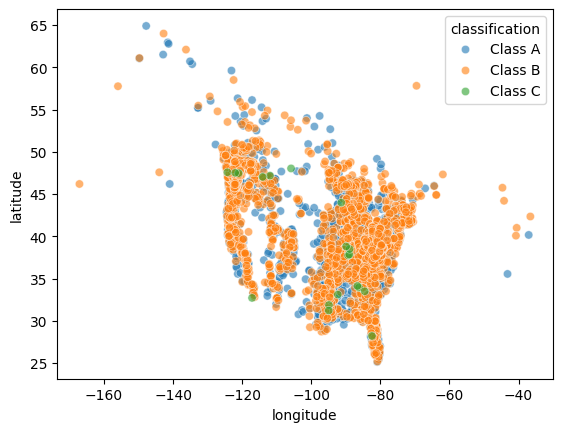

In [13]:
sns.scatterplot(x=locations_df['longitude'], y=locations_df['latitude'], hue=locations_df['classification'], alpha=0.6)

In [14]:
def one_hot_encode(data, col_name):
    data = pd.concat([data, pd.get_dummies(data[col_name], dtype=int)], axis=1)
    data.drop(col_name, axis=1, inplace=True)
    return data

In [15]:
locations_df = one_hot_encode(locations_df, 'classification')
locations_df

index  number                                              title  \
0         0     637  Report 637: Campers' encounter just after dark...   
1         1    2917  Report 2917: Family observes large biped from car   
2         2    7963  Report 7963: Sasquatch walks past window of ho...   
3         3    9317  Report 9317: Driver on Alcan Highway has noon,...   
4         4   13038  Report 13038: Snowmobiler has encounter in dee...   
...     ...     ...                                                ...   
4245   4245    4159  Report 4159: Campers hear unusual grunting sou...   
4246   4246     175  Report 175: Campers encounter large animal nea...   
4247   4247     945    Report 945: Creature with red glowing eyes seen   
4248   4248    1387  Report 1387: Father and son hear heavy footste...   
4249   4249    3044  Report 3044: Second-hand report of creature lo...   

                     timestamp  latitude  longitude  Class A  Class B  Class C  
0    2000-06-16 12:00:00+00:00  61.50000 -142.90000        1        0        0  
1    1995-05-15 12:00:00+00:00  55.18720 -132.79820        1        0        0  
2    2004-02-09 12:00:00+00:00  55.20350 -132.82020        1        0        0  
3    2004-06-18 12:00:00+00:00  62.93750 -141.56670        1        0        0  
4    2004-02-15 12:00:00+00:00  61.05950 -149.78530        1        0        0  
...                        ...       ...        ...      ...      ...      ...  
4245 1995-11-15 12:00:00+00:00  31.22333  -94.96611        0        0        1  
4246 2000-07-30 12:00:00+00:00  47.47745 -121.04150        0        0        1  
4247 1999-03-19 12:00:00+00:00  47.57778 -124.29330        0        0        1  
4248 1983-08-17 12:00:00+00:00  47.51030 -122.04560        0        0        1  
4249 1975-09-10 12:00:00+00:00  43.98694  -91.33662        0        0        1  

[4250 rows x 9 columns]

<Axes: >

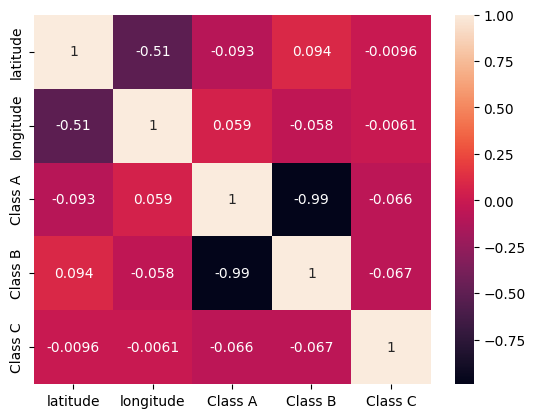

In [16]:
sns.heatmap(locations_df.drop(['index', 'number'], axis=1).corr(numeric_only=True), annot=True)

# BFRO Reports
- 5485 rows, many null entries
- Not doing a full EDA on this part of the data since the bfro_reports_geocoded is an already cleaned version of this
- Column Descriptions:
    - YEAR: Year of the sighting. (Integer)
    - SEASON: Season of the sighting. (String)
    - STATE: State of the sighting. (String)
    - COUNTY: County of the sighting. (String)
    - NEAREST_TOWN: Nearest town to the sighting. (String)
    - NEAREST_ROAD: Nearest road to the sighting. (String)
    - OBSERVED: Description of what was observed. (String)
    - ALSO_NOTICED: Any other details noticed during the sighting. (String)
    - OTHER_WITNESSES: Any other witnesses to the sighting. (String)
    - OTHER_STORIES: Any other stories related to the sighting. (String)
    - TIME_AND_CONDITIONS: Time and conditions of the sighting. (String)
    - ENVIRONMENT: Environment of the sighting. (String)
    - REPORT_NUMBER: Report number of the sighting. (Integer)
    - REPORT_CLASS: Classification of the sighting. (String)
    - LOCATION_DETAILS: Location details of the sighting. (String)
    - MONTH: Month of the sighting. (Integer)
    - DATE: Date of the sighting. (Integer)
    - A_&_G_References: Any references to the sighting. (String)


In [17]:
reports_df

index          YEAR  SEASON         STATE  \
0         0          2010  Summer       Alabama   
1         1  Early 1990's    Fall        Alaska   
2         2          1974    Fall  Rhode Island   
3         3      72 or 73  Summer  Pennsylvania   
4         4          1984  Spring        Oregon   
...     ...           ...     ...           ...   
5480   5480          2005  Summer    New Mexico   
5481   5481          1976  Spring      Maryland   
5482   5482          2011  Summer       Florida   
5483   5483          2015    Fall      Illinois   
5484   5484          1974  Summer      Illinois   

                              COUNTY                             NEAREST_TOWN  \
0                     Winston County                           Double Springs   
1     Valdez-Chitina-Whittier County                                      NaN   
2                  Washington County                                Wakefield   
3                        York County  York; more specifically Manchester twp.   
4                     Yamhill County                                  Yamhill   
...                              ...                                      ...   
5480               Rio Arriba County                                 dulce nm   
5481          Prince George's County                                      NaN   
5482                     Lake County                                 Sorrento   
5483                    White County                              Norris City   
5484                  Calhoun County                                   Hardin   

                     NEAREST_ROAD  \
0                      Highway 33   
1                             NaN   
2                      Perry Ave.   
3                   Raintree Road   
4                     NW Fairdale   
...                           ...   
5480                   (withheld)   
5481                          NaN   
5482      Mt.Plymouth rd/St.rt.46   
5483  Omitted for privacy reasons   
5484       Mississippi River Road   

                                               OBSERVED  \
0     I was canoeing on the Sipsey river in Alabama....   
1     Ed L. was salmon fishing with a companion in P...   
2     While attending U.R.I in the Fall of 1974,I wo...   
3     Hello, My name is Doug and though I am very re...   
4     It was May 1984. Two friends and I were up in ...   
...                                                 ...   
5480  while camping protecting other equipment befor...   
5481  I was on my way to work on a Saturday morning ...   
5482  On the twenty sixth and again on the twenty se...   
5483  I was hunting on me and my neighbor's property...   
5484  I was riding with a friend in the summer of 19...   

                                           ALSO_NOTICED  \
0     3 hours before on river while I paused to fix ...   
1                                                   NaN   
2                                                  none   
3     My friend noted that he had spent the night be...   
4     Not sure. It took me a full 5 years to be able...   
...                                                 ...   
5480                        no frist time camping there   
5481                                                NaN   
5482                                                NaN   
5483  Trees big around as pipe pvc snapped in half a...   
5484                        We didn't go back to check.   

                                        OTHER_WITNESSES  \
0                                                  none   
1     On a commercial fishing boat at anchor at the ...   
2                                                  none   
3     3. Don't remember the name of the third. He wa...   
4     There were two other wittness' other than me. ...   
...                                                 ...   
5480              one nephew, my two son where sleeping   
5481  I was on my way to work around 7 am on a Satur...   
5482                      

In [18]:
reports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5485 entries, 0 to 5484
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                5485 non-null   int64  
 1   YEAR                 5020 non-null   object 
 2   SEASON               5021 non-null   object 
 3   STATE                5021 non-null   object 
 4   COUNTY               5021 non-null   object 
 5   NEAREST_TOWN         4699 non-null   object 
 6   NEAREST_ROAD         4317 non-null   object 
 7   OBSERVED             4983 non-null   object 
 8   ALSO_NOTICED         3278 non-null   object 
 9   OTHER_WITNESSES      4467 non-null   object 
 10  OTHER_STORIES        3537 non-null   object 
 11  TIME_AND_CONDITIONS  4539 non-null   object 
 12  ENVIRONMENT          4747 non-null   object 
 13  REPORT_NUMBER        5021 non-null   float64
 14  REPORT_CLASS         5021 non-null   object 
 15  LOCATION_DETAILS     4260 non-null   o

# BFRO Reports Geocoded
- 5021 rows with many null entries except for county, state, season, and classification
- Column Descriptions:
    - title: The title of the sighting report. (String)
    - latitude: The latitude of the sighting. (Float)
    - longitude: The longitude of the sighting. (Float)
    - number: The report number of the sighting. (Integer)
    - classification: The classification of the sighting. (String)
    - observed: The date and time of the sighting. (DateTime)
    - observed: The date and time of the sighting. (DateTime)
    - location_details: The specific location of the sighting. (String)
    - county: The county in which the sighting occurred. (String)
    - state: The state in which the sighting occurred. (String)
    - season: The season in which the sighting occurred. (String)
    - geohash: The geohash of the sighting. (String)
    - temperature_high: The high temperature on the day of the sighting. (Float)
    - temperature_low: The low temperature on the day of the sighting. (Float)
    - dew_point: The dew point on the day of the sighting. (Float)
    - cloud_cover: The cloud cover on the day of the sighting. (Float)
    - moon_phase: The moon phase on the day of the sighting. (String)
    - precip_intensity: The precipitation intensity on the day of the sighting. (Float)
    - precip_probability: The precipitation probability on the day of the sighting. (Float)
    - precip_type: The type of precipitation on the day of the sighting. (String)
    - pressure: The atmospheric pressure on the day of the sighting. (Float)
    - summary: A summary of the weather conditions on the day of the sighting. (String)
    - visibility: The visibility on the day of the sighting. (Float)
    - wind_bearing: The wind bearing on the day of the sighting. (Integer)
    - wind_speed: The wind speed on the day of the sighting. (Float)


In [19]:
geocoded_df

index                                           observed  \
0         0  I was canoeing on the Sipsey river in Alabama....   
1         1  Ed L. was salmon fishing with a companion in P...   
2         2  While attending U.R.I in the Fall of 1974,I wo...   
3         3  Hello, My name is Doug and though I am very re...   
4         4  It was May 1984. Two friends and I were up in ...   
...     ...                                                ...   
5016   5016  while camping protecting other equipment befor...   
5017   5017  I was on my way to work on a Saturday morning ...   
5018   5018  On the twenty sixth and again on the twenty se...   
5019   5019  I was hunting on me and my neighbor's property...   
5020   5020  I was riding with a friend in the summer of 19...   

                                       location_details  \
0                                                   NaN   
1                     East side of Prince William Sound   
2                Great swamp area, Narragansett Indians   
3     I would rather not have exact location (listin...   
4     Logging roads north west of Yamhill, OR, about...   
...                                                 ...   
5016                                         (withheld)   
5017  Laurel, Maryland.  It was sighted off of Rt 19...   
5018  head n.on highway 441 from Orlando,then go eas...   
5019  It was on my neighbor's property in the woods ...   
5020  This happened on the Mississippi River Road in...   

                              county         state  season  \
0                     Winston County       Alabama  Summer   
1     Valdez-Chitina-Whittier County        Alaska    Fall   
2                  Washington County  Rhode Island    Fall   
3                        York County  Pennsylvania  Summer   
4                     Yamhill County        Oregon  Spring   
...                              ...           ...     ...   
5016               Rio Arriba County    New Mexico  Summer   
5017          Prince George's County      Maryland  Spring   
5018                     Lake County       Florida  Summer   
5019                    White County      Illinois    Fall   
5020                  Calhoun County      Illinois  Summer   

                                                  title  latitude  longitude  \
0                                                   NaN       NaN        NaN   
1                                                   NaN       NaN        NaN   
2     Report 6496: Bicycling student has night encou...     41.45      -71.5   
3                                                   NaN       NaN        NaN   
4                                                   NaN       NaN        NaN   
...                                                 ...       ...        ...   
5016                                                NaN       NaN        NaN   
5017                                                NaN       NaN        NaN   
5018                                                NaN       NaN        NaN   
5019                                                NaN       NaN        NaN   
5020                                                NaN       NaN        NaN   

            date  ...  moon_phase precip_intensity precip_probability  \
0            NaN  ...         NaN              NaN                NaN   
1            NaN  ...         NaN              NaN                NaN   
2     1974-09-20  ...        0.16              0.0                0.0   
3            NaN  ...         NaN              NaN                NaN   
4            NaN  ...         NaN              NaN                NaN   
...          ...  ...         ...              ...                ...   
5016         NaN  ...         NaN              NaN                NaN   
5017         NaN  ...         NaN              NaN                NaN   
5018         NaN  ...         NaN              NaN                NaN   
5019         NaN  ...         NaN              NaN                Na

In [20]:
geocoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               5021 non-null   int64  
 1   observed            4983 non-null   object 
 2   location_details    4260 non-null   object 
 3   county              5021 non-null   object 
 4   state               5021 non-null   object 
 5   season              5021 non-null   object 
 6   title               4045 non-null   object 
 7   latitude            4045 non-null   float64
 8   longitude           4045 non-null   float64
 9   date                4045 non-null   object 
 10  number              5021 non-null   float64
 11  classification      5021 non-null   object 
 12  geohash             4045 non-null   object 
 13  temperature_high    3338 non-null   float64
 14  temperature_mid     3186 non-null   float64
 15  temperature_low     3189 non-null   float64
 16  dew_po

In [21]:
geocoded_df = one_hot_encode(geocoded_df, 'classification')

In [35]:
geolocator = Nominatim(user_agent="Bigfootprint_Agent")
long_na = geocoded_df[geocoded_df['longitude'].isna()].copy()
backup = []

def get_lat_long(geolocator, county_state):
    location = geolocator.geocode(county_state)

    if not location:
        return np.nan, np.nan
    
    backup.append((location.latitude, location.longitude))
    
    return location.latitude, location.longitude

lat, long = zip(*long_na[['county', 'state']].agg(', '.join, axis=1)
             .map(lambda county_state: get_lat_long(geolocator, county_state)))

In [53]:
for geo_idx, df_idx in enumerate(long_na['index']):
    geocoded_df.loc[df_idx, "latitude"] = lat[geo_idx]
    geocoded_df.loc[df_idx, "longitude"] = long[geo_idx]

In [54]:
geocoded_df[geocoded_df['longitude'].isna()]

index                                           observed  \
1         1  Ed L. was salmon fishing with a companion in P...   
1166   1166  A friend and I were driving back to Fairbanks ...   
1167   1167  This is just a report from a native that said ...   
1196   1196  My name is Kevin and I've been hunting in Alas...   

                                       location_details  \
1                     East side of Prince William Sound   
1166  The incident occurred on the highway from Anch...   
1167  Skilak Lake Road by Skilak Lake Road in Kenai ...   
1196  down palmer fishhook 6 miles, right on sunvall...   

                              county   state season title  latitude  \
1     Valdez-Chitina-Whittier County  Alaska   Fall   NaN       NaN   
1166        Matanuska-Susitna County  Alaska   Fall   NaN       NaN   
1167         Kenai-Cook Inlet County  Alaska   Fall   NaN       NaN   
1196        Matanuska-Susitna County  Alaska   Fall   NaN       NaN   

      longitude date  ...  precip_type pressure  summary  uv_index  \
1           NaN  NaN  ...          NaN      NaN      NaN       NaN   
1166        NaN  NaN  ...          NaN      NaN      NaN       NaN   
1167        NaN  NaN  ...          NaN      NaN      NaN       NaN   
1196        NaN  NaN  ...          NaN      NaN      NaN       NaN   

      visibility  wind_bearing  wind_speed  Class A  Class B  Class C  
1            NaN           NaN         NaN        1        0        0  
1166         NaN           NaN         NaN        1        0        0  
1167         NaN           NaN         NaN        0        1        0  
1196         NaN           NaN         NaN        0        1        0  

[4 rows x 31 columns]

In [60]:
# Keep the rows that are not missing a lat/long
geocoded_df = geocoded_df[geocoded_df['latitude'].notna()]
geocoded_df

index                                           observed  \
0         0  I was canoeing on the Sipsey river in Alabama....   
2         2  While attending U.R.I in the Fall of 1974,I wo...   
3         3  Hello, My name is Doug and though I am very re...   
4         4  It was May 1984. Two friends and I were up in ...   
5         5  My two children and I were returning from Altu...   
...     ...                                                ...   
5016   5016  while camping protecting other equipment befor...   
5017   5017  I was on my way to work on a Saturday morning ...   
5018   5018  On the twenty sixth and again on the twenty se...   
5019   5019  I was hunting on me and my neighbor's property...   
5020   5020  I was riding with a friend in the summer of 19...   

                                       location_details  \
0                                                   NaN   
2                Great swamp area, Narragansett Indians   
3     I would rather not have exact location (listin...   
4     Logging roads north west of Yamhill, OR, about...   
5     The creature crossed from one cattle pasture t...   
...                                                 ...   
5016                                         (withheld)   
5017  Laurel, Maryland.  It was sighted off of Rt 19...   
5018  head n.on highway 441 from Orlando,then go eas...   
5019  It was on my neighbor's property in the woods ...   
5020  This happened on the Mississippi River Road in...   

                      county         state  season  \
0             Winston County       Alabama  Summer   
2          Washington County  Rhode Island    Fall   
3                York County  Pennsylvania  Summer   
4             Yamhill County        Oregon  Spring   
5             Washita County      Oklahoma    Fall   
...                      ...           ...     ...   
5016       Rio Arriba County    New Mexico  Summer   
5017  Prince George's County      Maryland  Spring   
5018             Lake County       Florida  Summer   
5019            White County      Illinois    Fall   
5020          Calhoun County      Illinois  Summer   

                                                  title   latitude  \
0                                                   NaN  34.132886   
2     Report 6496: Bicycling student has night encou...  41.450000   
3                                                   NaN  39.973143   
4                                                   NaN  45.229840   
5     Report 9765: Motorist and children have daylig...  35.301100   
...                                                 ...        ...   
5016                                                NaN  36.548827   
5017                                                NaN  38.803929   
5018                                                NaN  28.700686   
5019                                                NaN  38.063233   
5020                                                NaN  39.139751   

       longitude        date  ...  precip_type pressure  \
0     -87.361354         NaN  ...          NaN      NaN   
2     -71.500000  1974-09-20  ...          NaN  1020.61   
3     -76.742975         NaN  ...          NaN      NaN   
4    -123.218041         NaN  ...          NaN      NaN   
5     -99.170200  1973-09-28  ...         rain  1017.26   
...          ...         ...  ...          ...      ...   
5016 -106.815523         NaN  ...          NaN      NaN   
5017  -76.851870         NaN  ...          NaN      NaN   
5018  -81.789940         NaN  ...          NaN      NaN   
5019  -88.157772         NaN  ...          NaN      NaN   
5020  -90.650611         NaN  ...          NaN      NaN   

                                       summary  uv_index  visibility  \
0                                          NaN       NaN         NaN   
2                       Foggy until afternoon.       4.0        2.75   
3                                          NaN       NaN         NaN   
4                

In [61]:
geocoded_df.to_csv(Path('data/cleaned_csv.csv'), encoding='utf-8', index=False)

In [2]:
clean_csv = pd.read_csv('data/cleaned_csv.csv')

In [8]:
def make_heatmap(df):
    plt.figure(figsize=(16,5))
    geocoded_corr = df.drop(['index', 'number'], axis=1).corr(numeric_only=True)
    sns.heatmap(geocoded_corr, annot=True, mask=np.triu(geocoded_corr))

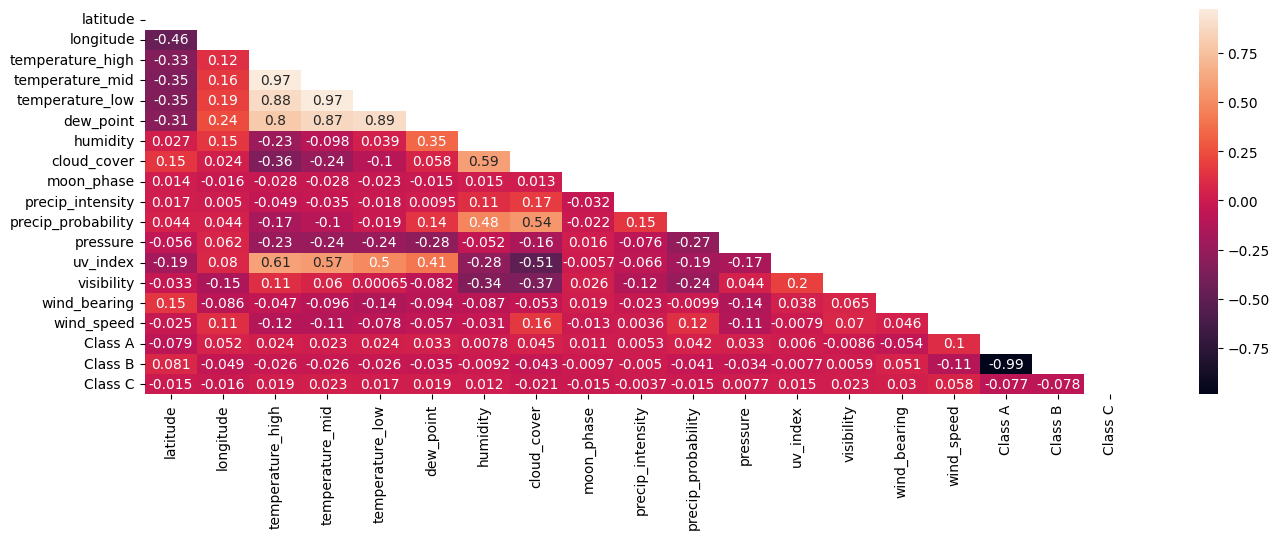

In [9]:
make_heatmap(clean_csv)

<Figure size 2400x600 with 0 Axes>

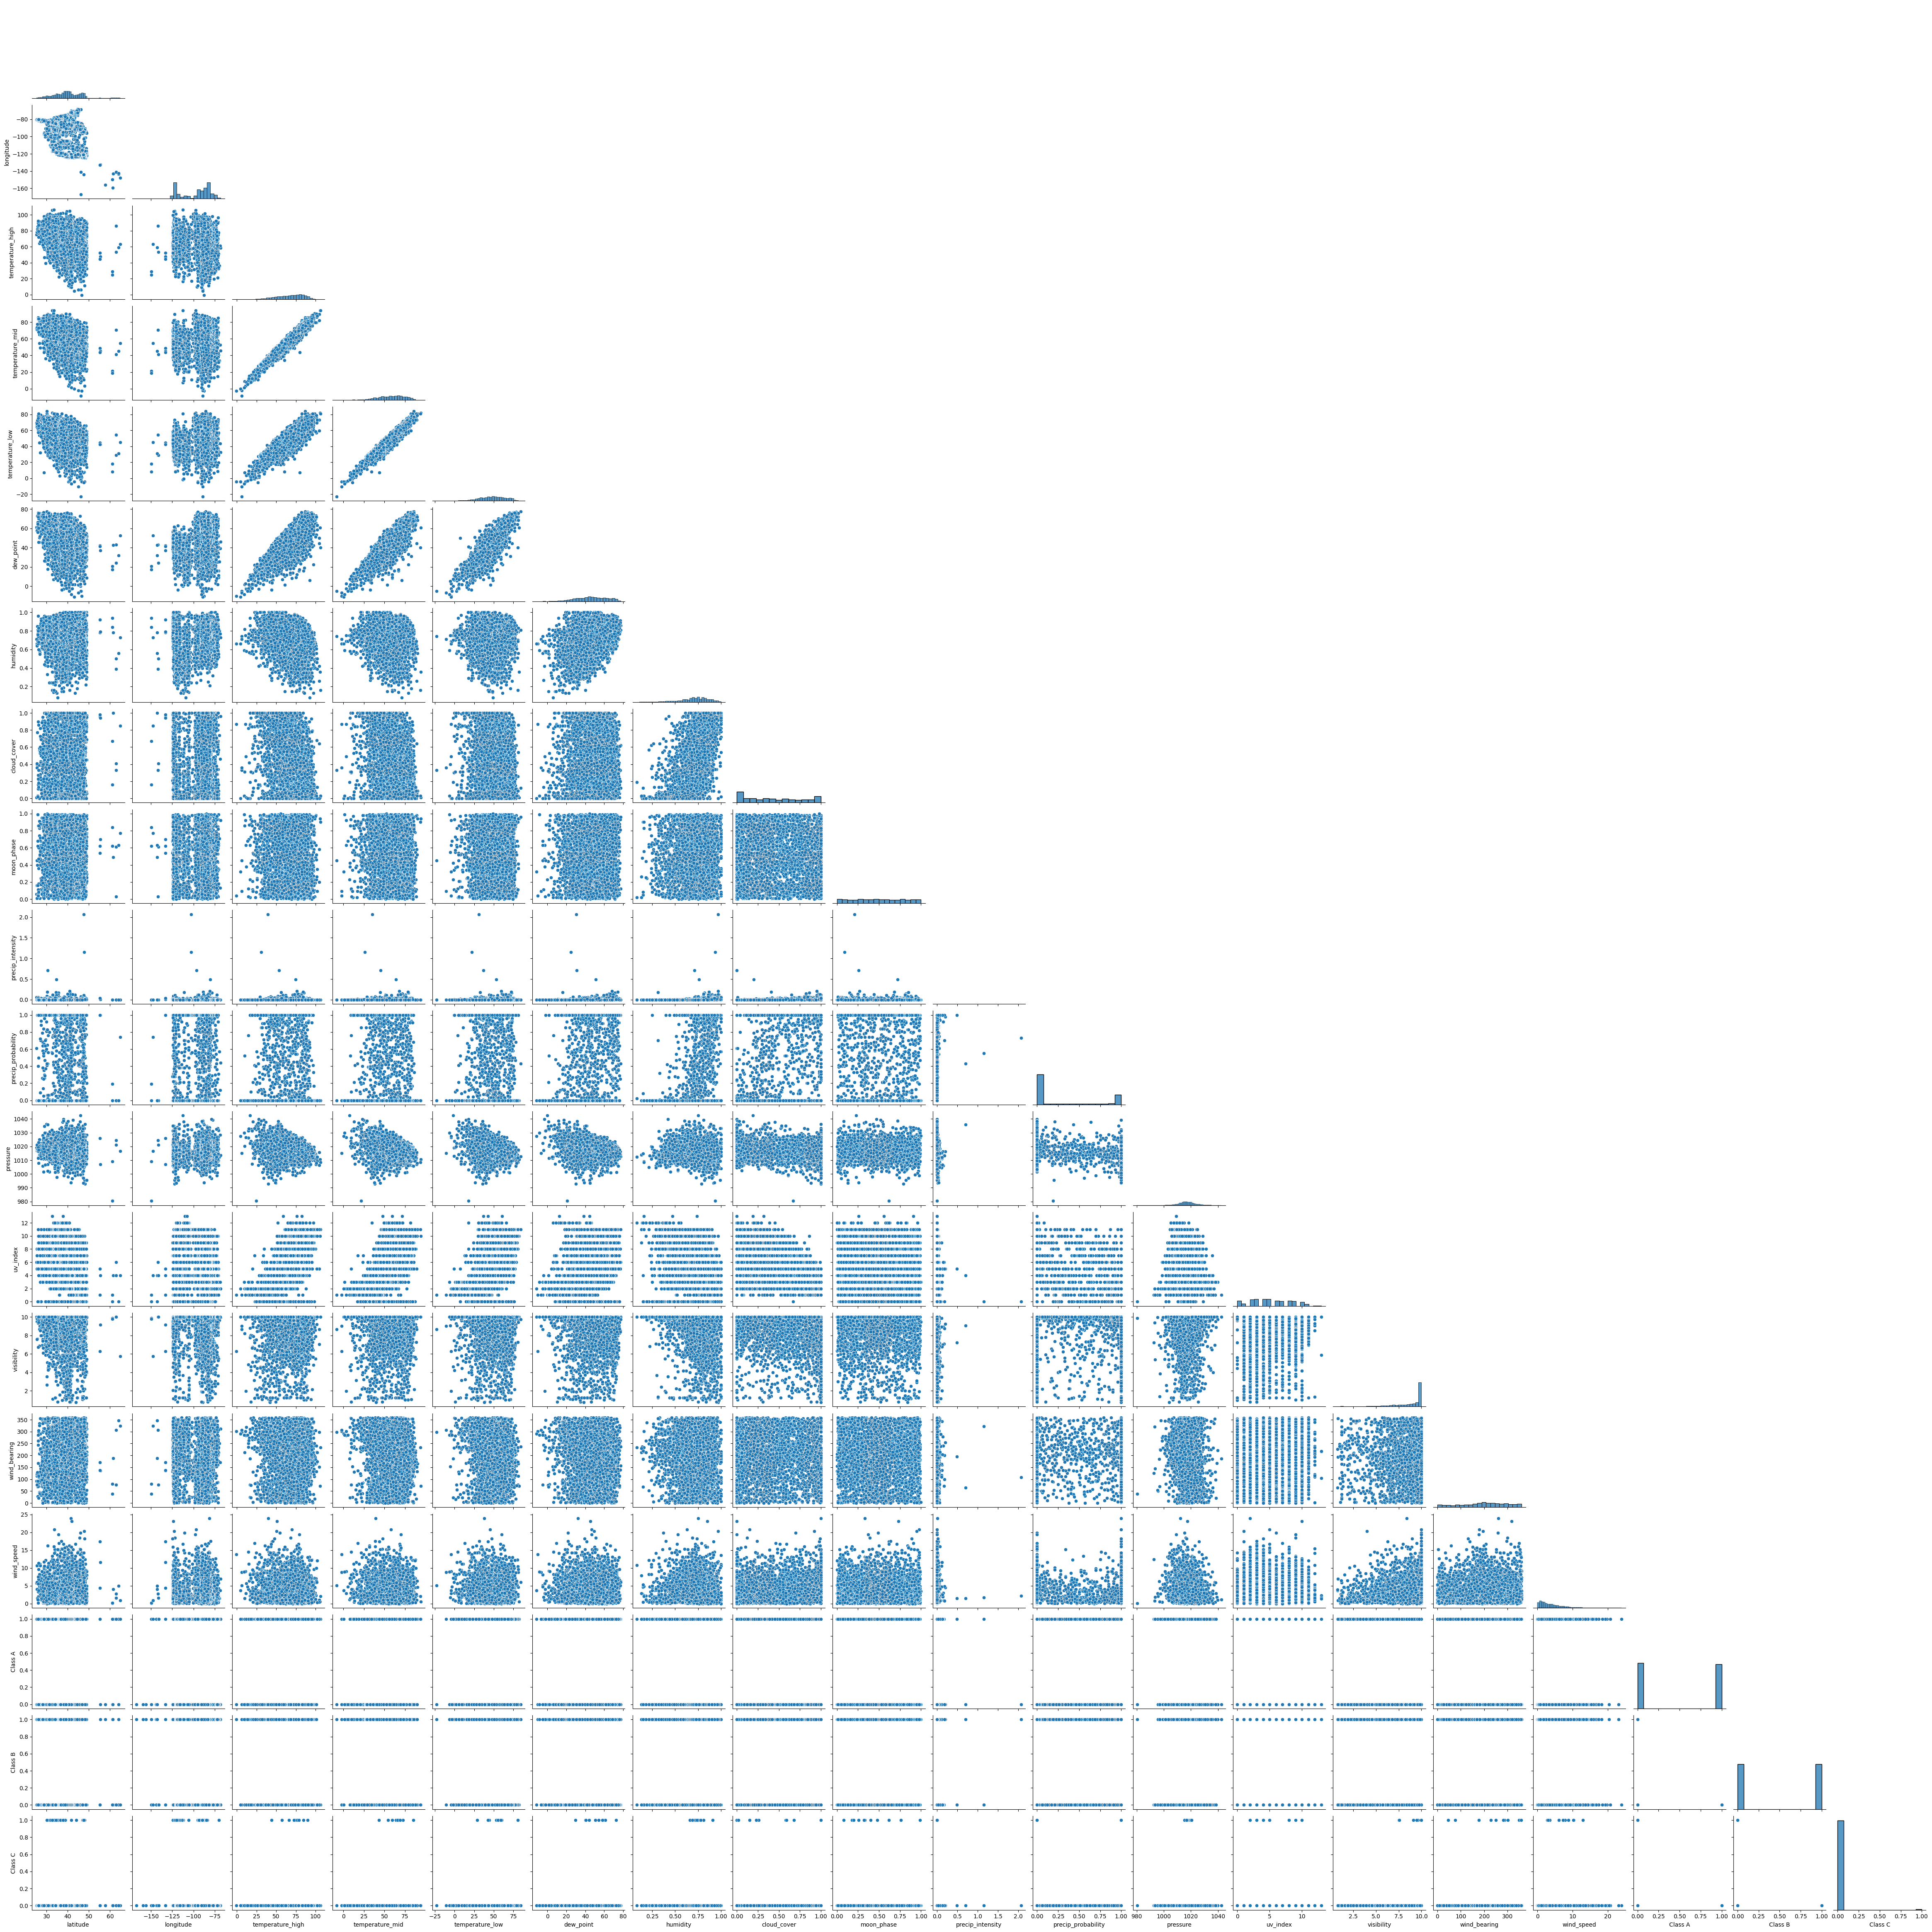

In [64]:
plt.figure(figsize=(24,6))
sns.pairplot(clean_csv.drop(['index', 'number'], axis=1), corner=True)

In [4]:
clean_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5017 entries, 0 to 5016
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               5017 non-null   int64  
 1   observed            4979 non-null   object 
 2   location_details    4256 non-null   object 
 3   county              5017 non-null   object 
 4   state               5017 non-null   object 
 5   season              5017 non-null   object 
 6   title               4045 non-null   object 
 7   latitude            5017 non-null   float64
 8   longitude           5017 non-null   float64
 9   date                4045 non-null   object 
 10  number              5017 non-null   float64
 11  geohash             4045 non-null   object 
 12  temperature_high    3338 non-null   float64
 13  temperature_mid     3186 non-null   float64
 14  temperature_low     3189 non-null   float64
 15  dew_point           3373 non-null   float64
 16  humidi

In [7]:
class_a_df = clean_csv[clean_csv['Class A'] == 1]
class_a_df

index                                           observed  \
1         2  While attending U.R.I in the Fall of 1974,I wo...   
4         5  My two children and I were returning from Altu...   
5         6  I was staying the night with a friends of mine...   
6         7  Well last year I was night fishing 9/2010 at A...   
9        10  I was on my way to Claremont from Lebanon on R...   
...     ...                                                ...   
5008   5012  The appearance of the thing was just as I have...   
5009   5013  OK, let me start by saying I have always been ...   
5010   5014  I was in my deer stand on near Taylorsville La...   
5013   5017  I was on my way to work on a Saturday morning ...   
5014   5018  On the twenty sixth and again on the twenty se...   

                                       location_details  \
1                Great swamp area, Narragansett Indians   
4     The creature crossed from one cattle pasture t...   
5           Vincent, Ohio (In theWayne National Forest)   
6     Both sightings were on the North east corner o...   
9     Close to Claremont down 120 not far from Kings...   
...                                                 ...   
5008  On Bods Mill Rd. there is a hidden entrance to...   
5009                       Removed at witness' request.   
5010  [Investigator (MM) Note: Private property roug...   
5013  Laurel, Maryland.  It was sighted off of Rt 19...   
5014  head n.on highway 441 from Orlando,then go eas...   

                      county          state  season  \
1          Washington County   Rhode Island    Fall   
4             Washita County       Oklahoma    Fall   
5          Washington County           Ohio  Summer   
6         Westchester County       New York    Fall   
9            Sullivan County  New Hampshire  Summer   
...                      ...            ...     ...   
5008         Anderson County       Kentucky    Fall   
5009         Anderson County       Kentucky    Fall   
5010         Anderson County       Kentucky    Fall   
5013  Prince George's County       Maryland  Spring   
5014             Lake County        Florida  Summer   

                                                  title   latitude  longitude  \
1     Report 6496: Bicycling student has night encou...  41.450000 -71.500000   
4     Report 9765: Motorist and children have daylig...  35.301100 -99.170200   
5     Report 4983: Sighting and vocalizations at a h...  39.387450 -81.673390   
6     Report 31940: Fishermen and Law Enforcement Of...  41.298730 -73.737170   
9     Report 55269: Dawn sighting at Stevens Brook o...  43.415490 -72.330930   
...                                                 ...        ...        ...   
5008  Report 1045: Father and son have a daylight en...  37.957080 -84.975270   
5009  Report 33187: Dual sighting in late afternoon ...  37.976990 -84.902340   
5010                                                NaN  38.009681 -84.988015   
5013                                                NaN  38.803929 -76.851870   
5014                                                NaN  28.700686 -81.789940   

            date  ...  precip_type pressure  \
1     1974-09-20  ...          NaN  1020.61   
4     1973-09-28  ...         rain  1017.26   
5     1971-08-01  ...          NaN      NaN   
6     2010-09-01  ...          NaN  1016.80   
9     2016-06-07  ...         rain   998.87   
...          ...  ...          ...      ...   
5008  2005-01-09  ...          NaN  1024.94   
5009  2011-11-15  ...         rain  1011.58   
5010         NaN  ...          NaN      NaN   
5013         NaN  ...          NaN      NaN   
5014         NaN  ...          NaN      NaN   

                                       summary  uv_index  visibility  \
1                       Foggy until afternoon.       4.0       2.750   
4     Partly cloudy starting in the afternoon.       7.0      10.000   
5                                          NaN       NaN         NaN   
6                

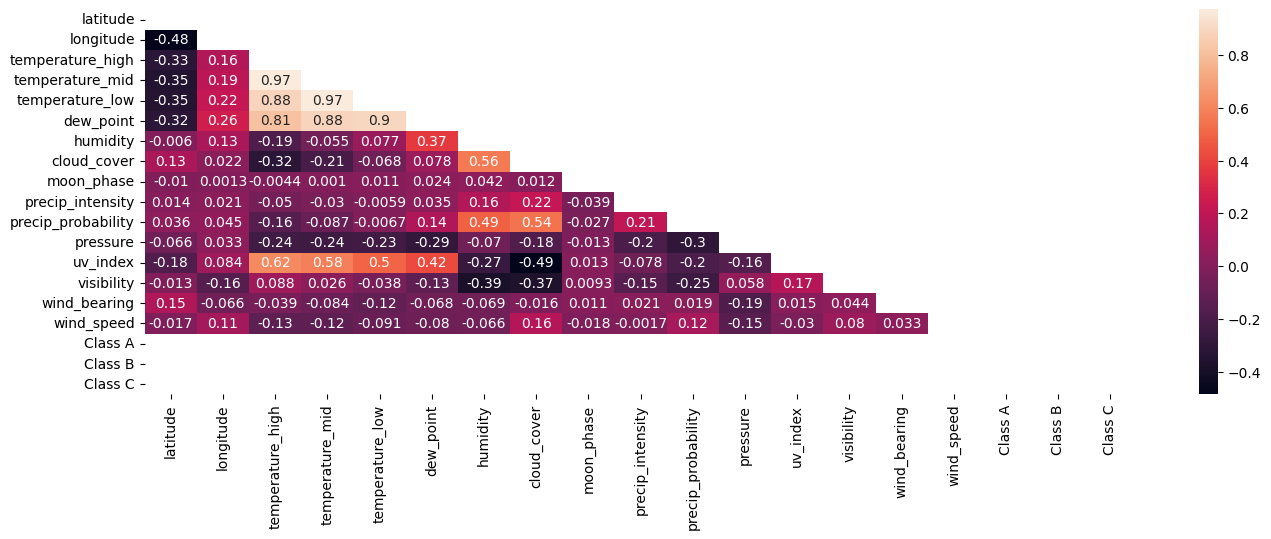

In [10]:
make_heatmap(class_a_df)

In [11]:
class_b_df = clean_csv[clean_csv['Class B'] == 1]
class_b_df

index                                           observed  \
0         0  I was canoeing on the Sipsey river in Alabama....   
2         3  Hello, My name is Doug and though I am very re...   
3         4  It was May 1984. Two friends and I were up in ...   
7         8  I grew up in Northwestern Nevada along the Cal...   
8         9  heh i kinda feel a little dumb that im reporti...   
...     ...                                                ...   
5006   5010  In October 2008 we went on a 4 wheeler trip to...   
5011   5015  My late Grandparents owned a home outside of S...   
5012   5016  while camping protecting other equipment befor...   
5015   5019  I was hunting on me and my neighbor's property...   
5016   5020  I was riding with a friend in the summer of 19...   

                                       location_details             county  \
0                                                   NaN     Winston County   
2     I would rather not have exact location (listin...        York County   
3     Logging roads north west of Yamhill, OR, about...     Yamhill County   
7     The Western face of Peavine Mountain, Northwes...      Washoe County   
8     the road is off us rt 80, i dont know the exit...      Warren County   
...                                                 ...                ...   
5006  Follow the railroad tracks East out of town an...      Harlan County   
5011  A few miles outside of Scottsville, Kentucky t...       Allen County   
5012                                         (withheld)  Rio Arriba County   
5015  It was on my neighbor's property in the woods ...       White County   
5016  This happened on the Mississippi River Road in...     Calhoun County   

             state  season                                              title  \
0          Alabama  Summer                                                NaN   
2     Pennsylvania  Summer                                                NaN   
3           Oregon  Spring                                                NaN   
7           Nevada    Fall  Report 5692: Father and son hear vocalizations...   
8       New Jersey    Fall                                                NaN   
...            ...     ...                                                ...   
5006      Kentucky    Fall  Report 25257: ATV riders find possible tracks ...   
5011      Kentucky  Spring  Report 22941: Man tells of Grandmother's encou...   
5012    New Mexico  Summer                                                NaN   
5015      Illinois    Fall                                                NaN   
5016      Illinois  Summer                                                NaN   

       latitude   longitude        date  ...  precip_type pressure  \
0     34.132886  -87.361354         NaN  ...          NaN      NaN   
2     39.973143  -76.742975         NaN  ...          NaN      NaN   
3     45.229840 -123.218041         NaN  ...          NaN      NaN   
7     39.592000 -119.975000  1970-09-01  ...          NaN  1012.31   
8     40.860222  -74.972049         NaN  ...          NaN      NaN   
...         ...         ...         ...  ...          ...      ...   
5006  36.897710  -83.162930  2008-10-15  ...          NaN      NaN   
5011  36.772000  -86.142500  2002-04-15  ...         rain  1015.98   
5012  36.548827 -106.815523         NaN  ...          NaN      NaN   
5015  38.063233  -88.157772         NaN  ...          NaN      NaN   
5016  39.139751  -90.650611         NaN  ...          NaN      NaN   

                            summary  uv_index  visibility  wind_bearing  \
0                               NaN       NaN         NaN           NaN   
2                               NaN       NaN         NaN           NaN   
3                               NaN       NaN         NaN           NaN   
7         Clear throughout the day.       8.0        8.88         285.0   
8                               NaN       NaN         NaN           NaN   
...         

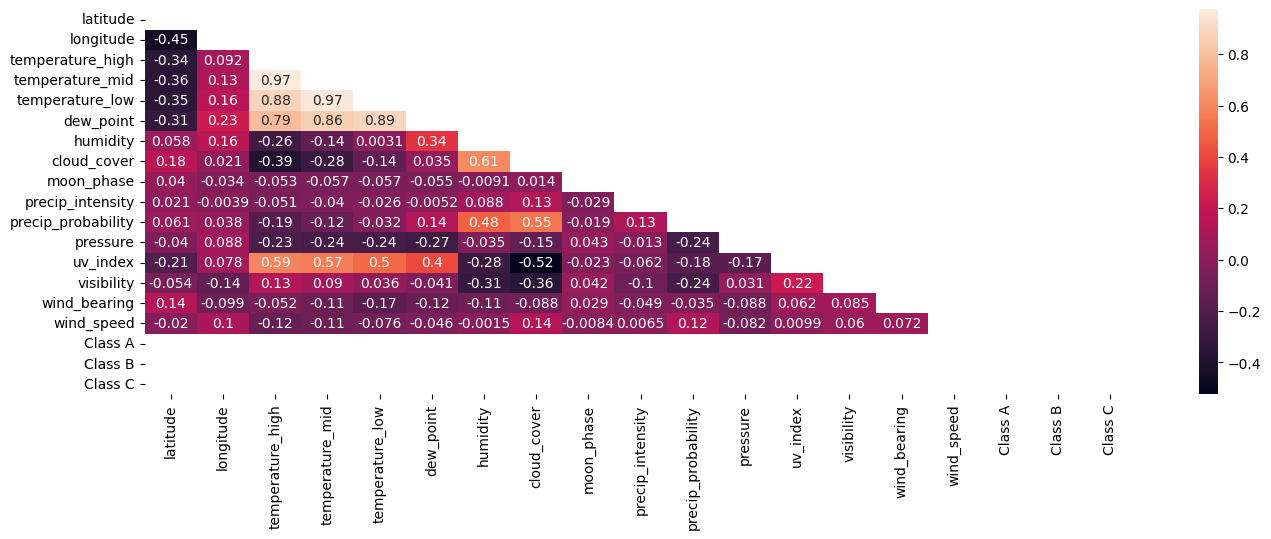

In [13]:
make_heatmap(class_b_df)

In [14]:
class_c_df = clean_csv[clean_csv['Class C'] == 1]
class_c_df

index                                           observed  \
67       68  It has been awhile since this incident happene...   
77       78  My half brother Shawn Flaten, my friend Monty ...   
79       80  During the night, horrible smells were noticed...   
633     634  We have 3 dogs: a 100-pound Rottweiler, a 70-p...   
1268   1272  I myself have never seen a bigfoot. But, I hav...   
1945   1949  I was told this story by my father I will do m...   
1997   2001  OBSERVED: My great aunt, Ida Jones told me tha...   
2026   2030  During the deer hunting season of Nov., 1995 w...   
2036   2040  My dad and I used to bowhunt deer on a lease t...   
2262   2266  This is my granpa's story, He said at about 9 ...   
2270   2274  While looking for arrowheads with my  wife and...   
2845   2849  A mexican brush picker in this area was pickin...   
2866   2870  One day during a hike through the woods, My fa...   
2922   2926  We were having a family reunion and on saturda...   
3007   3011  Over, I think, 20 to 25 years ago, a woman in ...   
3162   3166  this was years ago and the party involved  has...   
3169   3173  In the Fall of 1980 or 1981 two coworkers at N...   
3253   3257  Some friends of ours who live by the Ohio Rive...   
3271   3275  I live in Kansas City Mo the year was 1983 som...   
3299   3303  Third hand story.  Ten or so years ago, a lot ...   
3306   3310  Hairy manlike creature was after my great-gran...   
3441   3445  The local paper (The Press Enterprise), ran an...   
3459   3463  My book, "Night-Side of Gold," was written fro...   
3561   3565  This is not a sighting report. But it is a rep...   
3611   3615  Report of high-pitched whistling and movement ...   
3875   3879  In the distance a loud "howl" like sound was h...   
4520   4524  (#1) late July - early August 1968 (#2) 11 Aug...   
4616   4620  My mother observed a large, beige creature at ...   
4618   4622  The first incident occured on Monday night, 4 ...   
4746   4750  In the early eighties and late seventies many ...   

                                       location_details             county  \
67    It was in Montana on the Flathead Indian Reser...    Missoula County   
77    On the Missouri river bottom approx. 30 miles ...   Roosevelt County   
79    The "event" took place appx. 40 miles south of...     Cascade County   
633   Near my house on Route 52 in Utopia, Ohio (Bro...       Brown County   
1268  These both occurred in Blount county, Alabama....      Blount County   
1945  Montgomery County TN. Outside of cCarksville b...  Montgomery County   
1997  LOCATION: Carroll Co. Tennessee, in the south-...     Carroll County   
2026  About 5 miles east of Apple Springs in the Dav...     Trinity County   
2036  6 miles East of Recklaw off Highway 84 in the ...        Rusk County   
2262  This was north of Bear Valley. In the Tuscher ...     Millard County   
2270  Approx. 2 miles North of Manderfield between t...      Beaver County   
2845  Upper part of Grays Harbor County, Washington ...   Jefferson County   
2866  Squak Mountain, East of I-90. Squak Mt. is abo...        King County   
2922  If you follow the road through Cle Elum on thr...    Kittitas County   
3007                                                NaN   La Crosse County   
3162        mcelroy swamp, louisiana  ascension parish    Ascension Parish   
3169                                                NaN  Barnstable County   
3253                               Along the Ohio River       Boone County   
3271  Across the border from Missouri close to Fayet...     Madison County   
3299                      Union County, Near Strong, AR       Union County   
3306  Logan County Arkansas, Southwest of Booneville...       Logan County   
3441  County of Riverside, California: Anza Californ...   Riverside County   
3459                                                NaN   San Diego County   
3561  In Re: the Three Rivers sighting in Tulare, CA...      Tulare County   
3611     

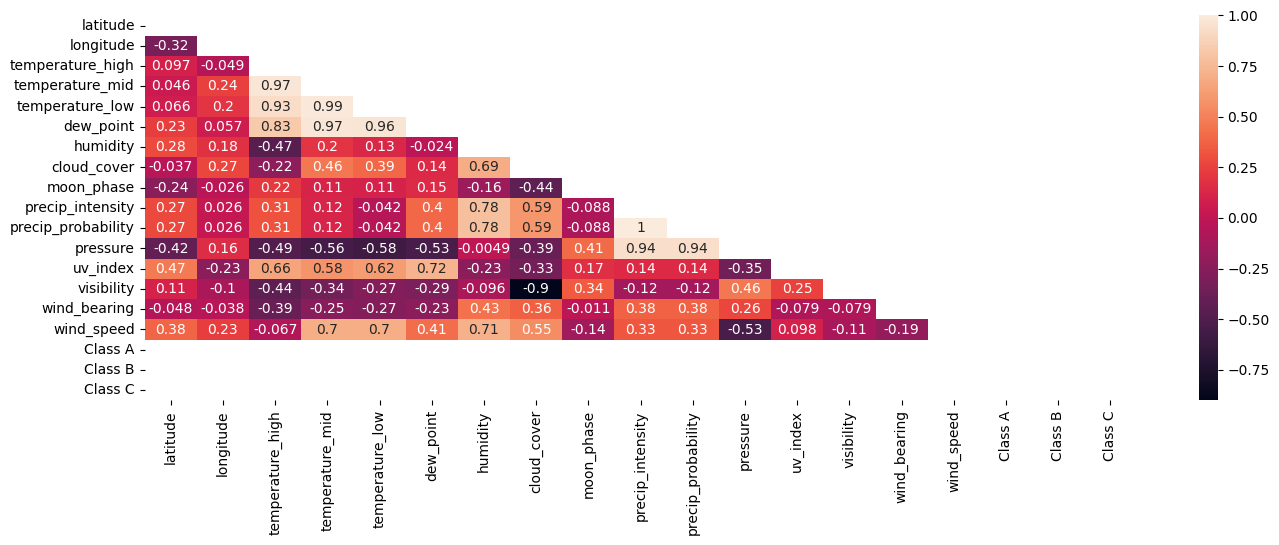

In [15]:
make_heatmap(class_c_df)

In [4]:
clean_csv = pd.read_csv('data/cleaned_csv.csv')
clean_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5017 entries, 0 to 5016
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               5017 non-null   int64  
 1   observed            4979 non-null   object 
 2   location_details    4256 non-null   object 
 3   county              5017 non-null   object 
 4   state               5017 non-null   object 
 5   season              5017 non-null   object 
 6   title               4045 non-null   object 
 7   latitude            5017 non-null   float64
 8   longitude           5017 non-null   float64
 9   date                4045 non-null   object 
 10  number              5017 non-null   float64
 11  geohash             4045 non-null   object 
 12  temperature_high    3338 non-null   float64
 13  temperature_mid     3186 non-null   float64
 14  temperature_low     3189 non-null   float64
 15  dew_point           3373 non-null   float64
 16  humidi

In [4]:
# https://open-meteo.com/en/docs/historical-weather-api
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
earliest_date = datetime.fromisoformat('1940-01-01')

def get_weather_data(lat, long, date):
    if datetime.fromisoformat(date) < earliest_date:
        return pd.DataFrame(), pd.DataFrame() 
        
    params = {
    	"latitude": lat,
    	"longitude": long,
    	"start_date": str(date),
    	"end_date": str(date),
    	"hourly": ["relative_humidity_2m", "dew_point_2m", "surface_pressure", "cloud_cover"],
    	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "wind_speed_10m_max", "wind_direction_10m_dominant"],
    	"temperature_unit": "fahrenheit",
    	"wind_speed_unit": "mph",
    	"precipitation_unit": "inch"
    }
    responses = openmeteo.weather_api(url, params=params)
    
    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    
    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_surface_pressure = hourly.Variables(2).ValuesAsNumpy()
    hourly_cloud_cover = hourly.Variables(3).ValuesAsNumpy()
    
    hourly_data = {"date": pd.date_range(
    	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    	freq = pd.Timedelta(seconds = hourly.Interval()),
    	inclusive = "left"
    )}
    hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
    hourly_data["dew_point_2m"] = hourly_dew_point_2m
    hourly_data["surface_pressure"] = hourly_surface_pressure
    hourly_data["cloud_cover"] = hourly_cloud_cover
    
    hourly_dataframe = pd.DataFrame(data = hourly_data)
    
    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_weather_code = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(4).ValuesAsNumpy()
    daily_wind_direction_10m_dominant = daily.Variables(5).ValuesAsNumpy()
    
    daily_data = {"date": pd.date_range(
    	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
    	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
    	freq = pd.Timedelta(seconds = daily.Interval()),
    	inclusive = "left"
    )}
    daily_data["weather_code"] = daily_weather_code
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant

    
    daily_dataframe = pd.DataFrame(data = daily_data)
    return daily_dataframe, hourly_dataframe

In [5]:
def create_wmo_table():
    wmo_weather_code_table = {
        20.0: 'rain',
        21.0: 'rain',
        22.0: 'snow',
        23.0: 'snow',
        24.0: 'rain',
        25.0: 'rain',
        26.0: 'snow',
        27.0: 'rain',
        80.0: 'rain',
        81.0: 'rain',
        82.0: 'rain',
        83.0: 'rain',
        84.0: 'rain',
        85.0: 'snow',
        86.0: 'snow',
        87.0: 'snow',
        88.0: 'snow',
    }

    for code in range(50, 70):
        wmo_weather_code_table[float(code)] = 'rain'
    for code in range(70, 80):
        wmo_weather_code_table[float(code)] = 'snow'
    for code in range(89, 100):
        wmo_weather_code_table[float(code)] = 'rain'

    return wmo_weather_code_table

def format_daily(daily_df, wmo_weather_code_table):
    precip_type = wmo_weather_code_table[daily_df['weather_code'].item()] if daily_df['weather_code'].item() in wmo_weather_code_table else 'No Precipitation'
    temp_high = daily_df['temperature_2m_max']
    temp_mid = daily_df['temperature_2m_mean']
    temp_low = daily_df['temperature_2m_min']
    wind_speed = daily_df['wind_speed_10m_max']
    wind_bearing = daily_df['wind_direction_10m_dominant']

    return precip_type, temp_high.item(), temp_mid.item(), temp_low.item(), wind_speed.item(), wind_bearing.item()

def aggregate_hourly(hourly_df):
    humidity = hourly_df['relative_humidity_2m'].mean() / 100.0
    dew_point = hourly_df['dew_point_2m'].mean()
    surface_pressure = hourly_df['surface_pressure'].mean()
    cloud_cover = hourly_df['cloud_cover'].mean() / 100.0

    return humidity, dew_point, surface_pressure, cloud_cover

In [91]:
date_df = clean_csv.loc[clean_csv['date'].notnull()].reset_index(drop=True)
date_df

index                                           observed  \
0         2  While attending U.R.I in the Fall of 1974,I wo...   
1         5  My two children and I were returning from Altu...   
2         6  I was staying the night with a friends of mine...   
3         7  Well last year I was night fishing 9/2010 at A...   
4         8  I grew up in Northwestern Nevada along the Cal...   
...     ...                                                ...   
4040   5010  In October 2008 we went on a 4 wheeler trip to...   
4041   5011  Went to get trail cams and see dark black figu...   
4042   5012  The appearance of the thing was just as I have...   
4043   5013  OK, let me start by saying I have always been ...   
4044   5015  My late Grandparents owned a home outside of S...   

                                       location_details              county  \
0                Great swamp area, Narragansett Indians   Washington County   
1     The creature crossed from one cattle pasture t...      Washita County   
2           Vincent, Ohio (In theWayne National Forest)   Washington County   
3     Both sightings were on the North east corner o...  Westchester County   
4     The Western face of Peavine Mountain, Northwes...       Washoe County   
...                                                 ...                 ...   
4040  Follow the railroad tracks East out of town an...       Harlan County   
4041                                                NaN       Harlan County   
4042  On Bods Mill Rd. there is a hidden entrance to...     Anderson County   
4043                       Removed at witness' request.     Anderson County   
4044  A few miles outside of Scottsville, Kentucky t...        Allen County   

             state  season                                              title  \
0     Rhode Island    Fall  Report 6496: Bicycling student has night encou...   
1         Oklahoma    Fall  Report 9765: Motorist and children have daylig...   
2             Ohio  Summer  Report 4983: Sighting and vocalizations at a h...   
3         New York    Fall  Report 31940: Fishermen and Law Enforcement Of...   
4           Nevada    Fall  Report 5692: Father and son hear vocalizations...   
...            ...     ...                                                ...   
4040      Kentucky    Fall  Report 25257: ATV riders find possible tracks ...   
4041      Kentucky  Winter  Report 38980: Teen on four-wheeler has sightin...   
4042      Kentucky    Fall  Report 1045: Father and son have a daylight en...   
4043      Kentucky    Fall  Report 33187: Dual sighting in late afternoon ...   
4044      Kentucky  Spring  Report 22941: Man tells of Grandmother's encou...   

      latitude  longitude        date  ...  precip_type pressure  \
0     41.45000  -71.50000  1974-09-20  ...          NaN  1020.61   
1     35.30110  -99.17020  1973-09-28  ...         rain  1017.26   
2     39.38745  -81.67339  1971-08-01  ...          NaN      NaN   
3     41.29873  -73.73717  2010-09-01  ...          NaN  1016.80   
4     39.59200 -119.97500  1970-09-01  ...          NaN  1012.31   
...        ...        ...         ...  ...          ...      ...   
4040  36.89771  -83.16293  2008-10-15  ...          NaN      NaN   
4041  36.83193  -83.42429  2013-01-10  ...          NaN      NaN   
4042  37.95708  -84.97527  2005-01-09  ...          NaN  1024.94   
4043  37.97699  -84.90234  2011-11-15  ...         rain  1011.58   
4044  36.77200  -86.14250  2002-04-15  ...         rain  1015.98   

                                       summary  uv_index  visibility  \
0                       Foggy until afternoon.       4.0       2.750   
1     Partly cloudy starting in the afternoon.       7.0      10.000   
2                                          NaN       NaN         NaN   
3                    Clear throughout the day.       8.0       6.922   
4                    Clear throughout the day.       8.0       8.880   
...                                       

In [8]:
def add_weather_data(df):
    humidity_col = df.columns.get_loc('humidity')
    dew_point_col = df.columns.get_loc('dew_point')
    surface_pressure_col = df.columns.get_loc('pressure')
    cloud_cover_col = df.columns.get_loc('cloud_cover')

    precip_type_col = df.columns.get_loc('precip_type')
    temp_high_col = df.columns.get_loc('temperature_high')
    temp_mid_col = df.columns.get_loc('temperature_mid')
    temp_low_col = df.columns.get_loc('temperature_low')
    wind_speed_col = df.columns.get_loc('wind_speed')
    wind_bearing_col = df.columns.get_loc('wind_bearing')

    wmo_table = create_wmo_table()

    curr_batch = 0
    for idx, lat, long, date in zip(df.index, df['latitude'], df['longitude'], df['date']):
        print(f'On: {idx}')
        daily_dataframe, hourly_dataframe = get_weather_data(lat, long, date)

        # In the event that data precedes the accessible range
        if daily_dataframe.empty or hourly_dataframe.empty:
            continue
            
        humidity, dew_point, surface_pressure, cloud_cover = aggregate_hourly(hourly_dataframe)
        precip_type, temp_high, temp_mid, temp_low, wind_speed, wind_bearing = format_daily(daily_dataframe, wmo_table)

        # https://open-meteo.com/en/terms 600 per min limit
        df.iloc[idx, humidity_col] = humidity
        df.iloc[idx, dew_point_col] = dew_point
        df.iloc[idx, surface_pressure_col] = surface_pressure
        df.iloc[idx, cloud_cover_col] = cloud_cover
        
        df.iloc[idx, precip_type_col] = precip_type
        df.iloc[idx, temp_high_col] = temp_high
        df.iloc[idx, temp_mid_col] = temp_mid
        df.iloc[idx, temp_low_col] = temp_low
        df.iloc[idx, wind_speed_col] = wind_speed
        df.iloc[idx, wind_bearing_col] = wind_bearing

        curr_batch += 1

        if curr_batch == 599:
            print('Waiting 60 seconds for API cooldown')
            time.sleep(60)
            curr_batch = 0
            print('Continuing')

In [127]:
add_weather_data(date_df)

On: 0
On: 1
On: 2
On: 3
On: 4
On: 5
On: 6
On: 7
On: 8
On: 9
On: 10
On: 11
On: 12
On: 13
On: 14
On: 15
On: 16
On: 17
On: 18
On: 19
On: 20
On: 21
On: 22
On: 23
On: 24
On: 25
On: 26
On: 27
On: 28
On: 29
On: 30
On: 31
On: 32
On: 33
On: 34
On: 35
On: 36
On: 37
On: 38
On: 39
On: 40
On: 41
On: 42
On: 43
On: 44
On: 45
On: 46
On: 47
On: 48
On: 49
On: 50
On: 51
On: 52
On: 53
On: 54
On: 55
On: 56
On: 57
On: 58
On: 59
On: 60
On: 61
On: 62
On: 63
On: 64
On: 65
On: 66
On: 67
On: 68
On: 69
On: 70
On: 71
On: 72
On: 73
On: 74
On: 75
On: 76
On: 77
On: 78
On: 79
On: 80
On: 81
On: 82
On: 83
On: 84
On: 85
On: 86
On: 87
On: 88
On: 89
On: 90
On: 91
On: 92
On: 93
On: 94
On: 95
On: 96
On: 97
On: 98
On: 99
On: 100
On: 101
On: 102
On: 103
On: 104
On: 105
On: 106
On: 107
On: 108
On: 109
On: 110
On: 111
On: 112
On: 113
On: 114
On: 115
On: 116
On: 117
On: 118
On: 119
On: 120
On: 121
On: 122
On: 123
On: 124
On: 125
On: 126
On: 127
On: 128
On: 129
On: 130
On: 131
On: 132
On: 133
On: 134
On: 135
On: 136
On: 137
On: 13

In [128]:
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4045 entries, 0 to 4044
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               4045 non-null   int64  
 1   observed            4012 non-null   object 
 2   location_details    3437 non-null   object 
 3   county              4045 non-null   object 
 4   state               4045 non-null   object 
 5   season              4045 non-null   object 
 6   title               4045 non-null   object 
 7   latitude            4045 non-null   float64
 8   longitude           4045 non-null   float64
 9   date                4045 non-null   object 
 10  number              4045 non-null   float64
 11  geohash             4045 non-null   object 
 12  temperature_high    4039 non-null   float64
 13  temperature_mid     4039 non-null   float64
 14  temperature_low     4039 non-null   float64
 15  dew_point           4039 non-null   float64
 16  humidi

In [132]:
date_df['precip_type'].value_counts()

No Precipitation    2151
rain                1641
snow                 247
Name: precip_type, dtype: int64

In [150]:
final_df = date_df.drop(['location_details', 'moon_phase', 'precip_intensity', 'precip_probability', 'summary', 'uv_index', 'visibility', 'observed'], axis=1).dropna()
final_df

index              county         state  season  \
0         2   Washington County  Rhode Island    Fall   
1         5      Washita County      Oklahoma    Fall   
2         6   Washington County          Ohio  Summer   
3         7  Westchester County      New York    Fall   
4         8       Washoe County        Nevada    Fall   
...     ...                 ...           ...     ...   
4040   5010       Harlan County      Kentucky    Fall   
4041   5011       Harlan County      Kentucky  Winter   
4042   5012     Anderson County      Kentucky    Fall   
4043   5013     Anderson County      Kentucky    Fall   
4044   5015        Allen County      Kentucky  Spring   

                                                  title  latitude  longitude  \
0     Report 6496: Bicycling student has night encou...  41.45000  -71.50000   
1     Report 9765: Motorist and children have daylig...  35.30110  -99.17020   
2     Report 4983: Sighting and vocalizations at a h...  39.38745  -81.67339   
3     Report 31940: Fishermen and Law Enforcement Of...  41.29873  -73.73717   
4     Report 5692: Father and son hear vocalizations...  39.59200 -119.97500   
...                                                 ...       ...        ...   
4040  Report 25257: ATV riders find possible tracks ...  36.89771  -83.16293   
4041  Report 38980: Teen on four-wheeler has sightin...  36.83193  -83.42429   
4042  Report 1045: Father and son have a daylight en...  37.95708  -84.97527   
4043  Report 33187: Dual sighting in late afternoon ...  37.97699  -84.90234   
4044  Report 22941: Man tells of Grandmother's encou...  36.77200  -86.14250   

            date   number     geohash  ...  dew_point  humidity  cloud_cover  \
0     1974-09-20   6496.0  drm5ucxrc0  ...  66.227150  0.907111     0.268375   
1     1973-09-28   9765.0  9y32z667yc  ...  47.139355  0.646660     0.113750   
2     1971-08-01   4983.0  dpjbj6r280  ...  60.795803  0.745234     0.584542   
3     2010-09-01  31940.0  dr7dfn4nx3  ...  63.793255  0.578789     0.126625   
4     1970-09-01   5692.0  9r49jzsb5g  ...  29.029099  0.402105     0.000000   
...          ...      ...         ...  ...        ...       ...          ...   
4040  2008-10-15  25257.0  dnscgt48er  ...  54.413593  0.740113     0.151125   
4041  2013-01-10  38980.0  dns9t9h391  ...  47.541798  0.930158     0.878042   
4042  2005-01-09   1045.0  dnexfmfuh8  ...  33.796551  0.793257     0.548708   
4043  2011-11-15  33187.0  dng8h18000  ...  56.680698  0.936365     0.963083   
4044  2002-04-15  22941.0  dnd9py0uqm  ...  60.455750  0.809660     0.151500   

           precip_type     pressure  wind_bearing wind_speed  Class A  \
0                 rain  1019.476257    263.869568  11.258579        1   
1     No Precipitation   953.307434    164.583038  14.922651        1   
2     No Precipitation   993.191711     17.920425   4.966946        1   
3     No Precipitation  1001.331787    270.616058   6.397976        1   
4     No Precipitation   807.823975    219.053116   9.812248        0   
...                ...          ...           ...        ...      ...   
4040  No Precipitation   911.663757    201.991241   5.410581        0   
4041              rain   980.778503     89.679916   6.219504        1   
4042  No Precipitation   995.131042    178.840332   7.880466        1   
4043              rain   984.935791    201.164108  13.016956        1   
4044              rain   985.680969    195.516541   9.398062        0   

      Class B  Class C  
0           0        0  
1           0        0  
2           0        0  
3           0        0  
4           1        0  
...       ...      ...  
4040        1        0  
4041        0        0  
4042        0        0  
4043        0        0  
4044        1        0  

[4039 rows x 23 columns]

In [151]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4039 entries, 0 to 4044
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4039 non-null   int64  
 1   county            4039 non-null   object 
 2   state             4039 non-null   object 
 3   season            4039 non-null   object 
 4   title             4039 non-null   object 
 5   latitude          4039 non-null   float64
 6   longitude         4039 non-null   float64
 7   date              4039 non-null   object 
 8   number            4039 non-null   float64
 9   geohash           4039 non-null   object 
 10  temperature_high  4039 non-null   float64
 11  temperature_mid   4039 non-null   float64
 12  temperature_low   4039 non-null   float64
 13  dew_point         4039 non-null   float64
 14  humidity          4039 non-null   float64
 15  cloud_cover       4039 non-null   float64
 16  precip_type       4039 non-null   object 


In [152]:
final_df = final_df.reset_index(drop=True)

In [153]:
final_df.to_csv('./data/clean_data_with_date_weather.csv')

In [156]:
df = pd.read_csv('./data/clean_data_with_date_weather.csv', index_col=0)
df

index              county         state  season  \
0         2   Washington County  Rhode Island    Fall   
1         5      Washita County      Oklahoma    Fall   
2         6   Washington County          Ohio  Summer   
3         7  Westchester County      New York    Fall   
4         8       Washoe County        Nevada    Fall   
...     ...                 ...           ...     ...   
4034   5010       Harlan County      Kentucky    Fall   
4035   5011       Harlan County      Kentucky  Winter   
4036   5012     Anderson County      Kentucky    Fall   
4037   5013     Anderson County      Kentucky    Fall   
4038   5015        Allen County      Kentucky  Spring   

                                                  title  latitude  longitude  \
0     Report 6496: Bicycling student has night encou...  41.45000  -71.50000   
1     Report 9765: Motorist and children have daylig...  35.30110  -99.17020   
2     Report 4983: Sighting and vocalizations at a h...  39.38745  -81.67339   
3     Report 31940: Fishermen and Law Enforcement Of...  41.29873  -73.73717   
4     Report 5692: Father and son hear vocalizations...  39.59200 -119.97500   
...                                                 ...       ...        ...   
4034  Report 25257: ATV riders find possible tracks ...  36.89771  -83.16293   
4035  Report 38980: Teen on four-wheeler has sightin...  36.83193  -83.42429   
4036  Report 1045: Father and son have a daylight en...  37.95708  -84.97527   
4037  Report 33187: Dual sighting in late afternoon ...  37.97699  -84.90234   
4038  Report 22941: Man tells of Grandmother's encou...  36.77200  -86.14250   

            date   number     geohash  ...  dew_point  humidity  cloud_cover  \
0     1974-09-20   6496.0  drm5ucxrc0  ...  66.227150  0.907111     0.268375   
1     1973-09-28   9765.0  9y32z667yc  ...  47.139355  0.646660     0.113750   
2     1971-08-01   4983.0  dpjbj6r280  ...  60.795803  0.745234     0.584542   
3     2010-09-01  31940.0  dr7dfn4nx3  ...  63.793255  0.578789     0.126625   
4     1970-09-01   5692.0  9r49jzsb5g  ...  29.029099  0.402105     0.000000   
...          ...      ...         ...  ...        ...       ...          ...   
4034  2008-10-15  25257.0  dnscgt48er  ...  54.413593  0.740113     0.151125   
4035  2013-01-10  38980.0  dns9t9h391  ...  47.541798  0.930158     0.878042   
4036  2005-01-09   1045.0  dnexfmfuh8  ...  33.796551  0.793257     0.548708   
4037  2011-11-15  33187.0  dng8h18000  ...  56.680698  0.936365     0.963083   
4038  2002-04-15  22941.0  dnd9py0uqm  ...  60.455750  0.809660     0.151500   

           precip_type     pressure  wind_bearing wind_speed  Class A  \
0                 rain  1019.476257    263.869568  11.258579        1   
1     No Precipitation   953.307434    164.583038  14.922651        1   
2     No Precipitation   993.191711     17.920425   4.966946        1   
3     No Precipitation  1001.331787    270.616058   6.397976        1   
4     No Precipitation   807.823975    219.053116   9.812248        0   
...                ...          ...           ...        ...      ...   
4034  No Precipitation   911.663757    201.991241   5.410581        0   
4035              rain   980.778503     89.679916   6.219504        1   
4036  No Precipitation   995.131042    178.840332   7.880466        1   
4037              rain   984.935791    201.164108  13.016956        1   
4038              rain   985.680969    195.516541   9.398062        0   

      Class B  Class C  
0           0        0  
1           0        0  
2           0        0  
3           0        0  
4           1        0  
...       ...      ...  
4034        1        0  
4035        0        0  
4036        0        0  
4037        0        0  
4038        1        0  

[4039 rows x 23 columns]

In [16]:
def create_model_input(lat, long, date):
    df = pd.DataFrame(data={'latitude': [lat], 'longitude': [long], 'date': [date],  'temperature_high': [np.nan],
                        'temperature_mid': [np.nan], 'temperature_low': [np.nan], 'dew_point': [np.nan], 'humidity': [np.nan],
                        'cloud_cover': [np.nan], 'pressure': [np.nan], 'wind_bearing': [np.nan], 'wind_speed': [np.nan],
                        'Fall': 0, 'Spring': 0, 'Summer': 0, 'Winter': 0, 'No Precipitation': 0, 'rain': 0, 
                        'precip_type': [np.nan]})
    add_weather_data(df)
    df.to_csv('./data/test_input.csv')

In [17]:
create_model_input(44.00, -120.50, '2024-05-01')

On: 0
